# Building a Deep Learning workshop sound classifier

In [ ]:
import os

In [ ]:
!pip3 install --upgrade matplotlib
!pip3 install tensorflow-io

os.kill(os.getpid(), 9)  # Restart runtime after installing missing packages

In [97]:
import pathlib
import zipfile

import numpy as np
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras.utils import plot_model

from google.colab import drive

from IPython import display

In [1]:
# Let's check if we have GPU acceleration available
!nvidia-smi

Mon Apr 25 14:07:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Getting the data


In [4]:
# Connect to Google Drive
DRIVE_PATH = "/content/drive"

drive.mount(DRIVE_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Extract zip file containing the audio dataset
DATASET_FILE = DRIVE_PATH + "/MyDrive/dataset.zip"

zipref = zipfile.ZipFile(DATASET_FILE, "r")
zipref.extractall("/content/")
zipref.close()

In [6]:
# Get dataset files and labels
DATASET_PATH = "/content/dataset"

data_dir = pathlib.Path(DATASET_PATH)
labels = tf.io.gfile.listdir(data_dir)

print(f"Available labels: {labels}\n")

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*') # Returns a list of files
                                                     # matching with expression
filenames[:5]

Available labels: ['mill', 'environment', 'saw']



['/content/dataset/environment/environmental_1072.wav',
 '/content/dataset/environment/environmental_1012.wav',
 '/content/dataset/environment/environmental_634.wav',
 '/content/dataset/environment/environmental_962.wav',
 '/content/dataset/environment/environmental_132.wav']

In [7]:
# Shuffling file list for training performance
filenames_shuffled = tf.random.shuffle(filenames, seed = 42)
filenames_shuffled[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'/content/dataset/mill/mill_3523.wav',
       b'/content/dataset/mill/mill_4303.wav',
       b'/content/dataset/saw/saw_141.wav',
       b'/content/dataset/environment/environmental_1073.wav',
       b'/content/dataset/mill/mill_927.wav'], dtype=object)>

In [8]:
# Getting number of samples of each label
num_samples = {}

for label in labels:
  num_samples[label] = len(tf.io.gfile.listdir(str(data_dir/label)))

num_samples

{'environment': 1079, 'mill': 5814, 'saw': 1401}

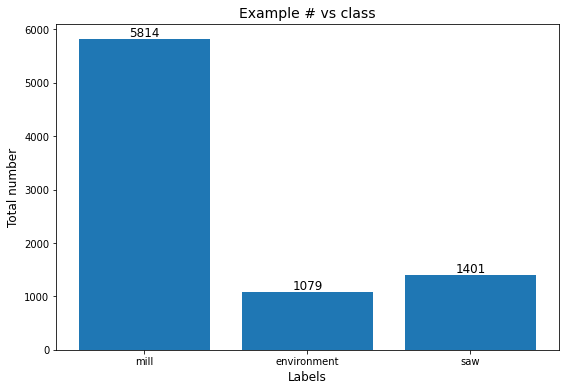

In [33]:
# Plotting the number of samples in each label in a bar plot
fig, ax = plt.subplots(figsize = (9, 6))
bars = ax.bar(num_samples.keys(), num_samples.values())
ax.bar_label(bars, fontsize = 12)
plt.title("Example # vs class", fontsize = 14)
plt.xlabel("Labels", fontsize = 12)
plt.ylabel("Total number", fontsize = 12)
plt.savefig("/content/class_hist.png", dpi = 600)
plt.show()

Notice the important imbalance among the labels. We have roughly **4x more examples in the mill class** with respect to the other two.

This will have an impact in the way our models learn that we'll discuss later.

### Splitting the data into train and validation sets

We'll use a 80/20 proportion.

In [40]:
num_examples = len(filenames_shuffled)

train_files = filenames_shuffled[:int(num_examples* 0.8)]
test_files = filenames_shuffled[int(num_examples*0.8):]

len(train_files), len(test_files), num_examples

(6635, 1659, 8294)

In [41]:
train_files[:2], test_files[:2]

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'/content/dataset/mill/mill_3523.wav',
        b'/content/dataset/mill/mill_4303.wav'], dtype=object)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'/content/dataset/mill/mill_1630.wav',
        b'/content/dataset/mill/mill_2313.wav'], dtype=object)>)

### Reading the waveforms
Our files use a sample rate of 44100 Hz and each file lasts for 0.5 s

In [42]:
SAMPLE_RATE = 44100

In [46]:
# Reading a random waveform
random_path =  random.choice(train_files)
random_file = tf.io.read_file(random_path)  # Returns a binary string of data

random_path, random_file

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/mill/mill_2632.wav'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'RIFF`\xb0\x00\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00D\xac\x00\x00\x88X\x01\x00\x02\x00\x10\x00LIST4\x00\x00\x00INFOINAM\x08\x00\x00\x00mill_04\x00IPRT\x02\x00\x00\x004\x00ISFT\x0e\x00\x00\x00Lavf58.45.100\x00data\x00\xb0\x00\x00\x10\r\x92\x0b\xa1\x08\xd7\x04J\x01\'\xff{\xfei\xfdK\xfb\x08\xfa\xfe\xfa\xc7\xfc\r\xfe_\xffE\x02m\x07\xff\r\xeb\x13\xd3\x17+\x1ar\x1bI\x1b\x07\x1a\x19\x18+\x15\xdf\x11\x16\x0fd\x0c\n\n\x8d\x08g\x08\xcd\x0by\x13\x1c\x1a\xd3\x1b\x03\x1a(\x15\xc8\r\xee\x08X\x08\xbd\x07\x1a\x06\xc1\x06\x96\t\xfd\n\x19\n\xb7\tS\x0c,\x11\x01\x16^\x19\xe8\x1a\xbe\x1a\xe4\x18S\x15\xa9\x11&\x10\x89\x10\xc3\x10\xf1\x0f\xa5\x0e\x17\r\x05\x0b\xa2\x08\xf1\x06\xf3\x05\x07\x04<\x00i\xfc:\xfb\xe2\xfb\x8c\xfbp\xfa\xe7\xf9\xc9\xf8?\xf6\xe9\xf2\xe3\xeev\xec[\xeeo\xf1\\\xf2,\xf4\xf0\xf7i\xf9E\xf8\xc9\xf71\xf8\xc8\xf7\xe6\xf5~\xf2p\xeft\xef\x89\xf1\xa3\xf2\xf6\xf2\xdb

In [52]:
# Decoding the binary string into a waveform, and playing it
test_audio, sample_rate = tf.audio.decode_wav(random_file,
                                              desired_samples = int(SAMPLE_RATE/2))
print("Audio clip: ")
display.display(display.Audio(tf.squeeze(test_audio).numpy(), rate = SAMPLE_RATE))
print("\n")
test_audio, sample_rate

Audio clip: 


(<tf.Tensor: shape=(22050, 1), dtype=float32, numpy=
 array([[ 0.10205078],
        [ 0.09039307],
        [ 0.06741333],
        ...,
        [-0.12316895],
        [-0.16488647],
        [-0.1652832 ]], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int32, numpy=44100>)

Now that we know how to read in files and turn them into arrays, let's
functionize the code so that we can apply it to the whole dataset.

In [53]:
# Function to read in a .wav file and return an array
def get_waveform(audio_binary, desired_samples = int(SAMPLE_RATE/2)):
  """
  Takes in a binary string and returns an array of float32 audio components.
  """
  waveform, _ = tf.audio.decode_wav(contents = audio_binary,
                                    desired_samples = desired_samples)
  return tf.squeeze(waveform, axis = -1)  # Recovered two channels, but only one
                                          # contains information

In [54]:
# Function to get the waveform label, given the file path
def get_label(file_path):
  """
  Takes in an audio file path and returns its label, i.e., it's parent directory
  name.
  """
  parts = tf.strings.split(
      input = file_path,
      sep = os.path.sep  # i.e. "/"
  )
  return parts[-2]  # /contents/dataset/mill/mill_0123.wav
                    # [|  -4  ||  -3  || -2 ||    -1     |]    

In [61]:
# Bringing it all together
def get_waveform_and_label(filepath, desired_samples = int(SAMPLE_RATE)/2):
  """
  Takes in a file path and returns a tuple containing the decoded waveform and its
  class.
  """
  audio_binary = tf.io.read_file(filepath)
  waveform = get_waveform(audio_binary, desired_samples = desired_samples)
  label = get_label(filepath)
  return waveform, label

In [71]:
# Trying out the function
random_path = random.choice(train_files)
random_waveform, label = get_waveform_and_label(filepath = random_path)

random_waveform, label

(<tf.Tensor: shape=(22050,), dtype=float32, numpy=
 array([0.11825562, 0.12524414, 0.1178894 , ..., 0.08413696, 0.07919312,
        0.13433838], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'mill'>)

### Building a waveform TensorFlow dataset

It will consist of tuples containing a waveform and it's assigned label

In [72]:
# First create a file dataset, and then apply map functions to get the final
# result
files_dataset = tf.data.Dataset.from_tensor_slices(train_files)
waveform_dataset = files_dataset.map(
    map_func = get_waveform_and_label,
    num_parallel_calls = tf.data.AUTOTUNE
)

waveform_dataset

<ParallelMapDataset element_spec=(TensorSpec(shape=(22050,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

#### Visualizing some random waveforms and their labels

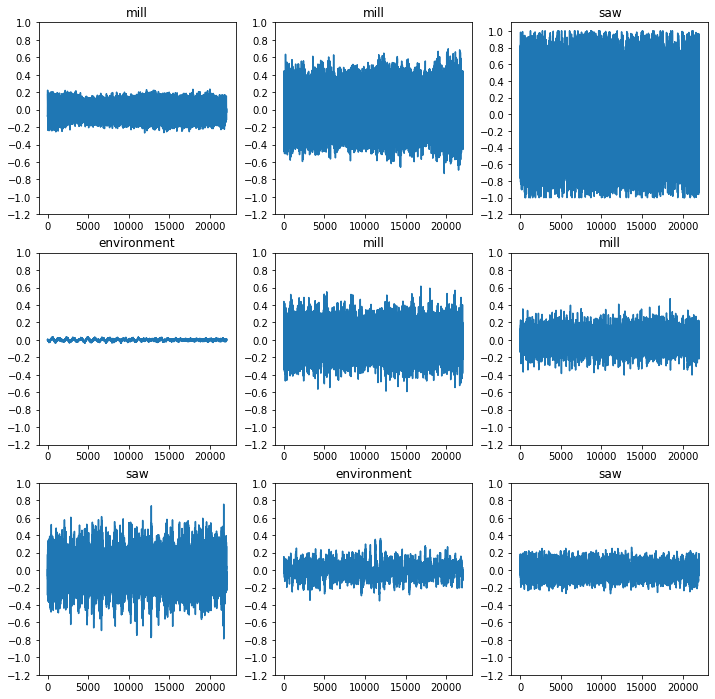

In [93]:
num_rows = 3
num_cols = 3

n = num_rows * num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 12))

for i, (waveform, label) in enumerate (waveform_dataset.take(n)):
  r = i // num_cols  # Returns quotient of int division
  c = i % num_cols  # Returns remainder of int division

  ax = axes[r][c]
  ax.plot(waveform.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode("utf-8")
  ax.set_title(label)
plt.savefig("/content/waveform_grid.png", dpi = 600)
plt.show()

### Building a spectrogram TensorFlow dataset

Though we could theoretically start DL experiments with the data we already have, sound recognition works best when we factor in the frequency component. Introducing spectrograms.

In [118]:
# Building a function for getting a waveform spectrogram
def get_spectrogram(waveform, frame_length = 512, frame_step = 96):
  """
  Takes in a waveform array, and returns a spectrogram represented as a tensor.
  """
  spectrogram = tfio.audio.spectrogram(
      waveform,
      nfft = frame_length,
      window = frame_length,
      stride = frame_step)
  return tf.expand_dims(spectrogram, axis = -1)  # Return the right shape for
                                                 # using a CNN  

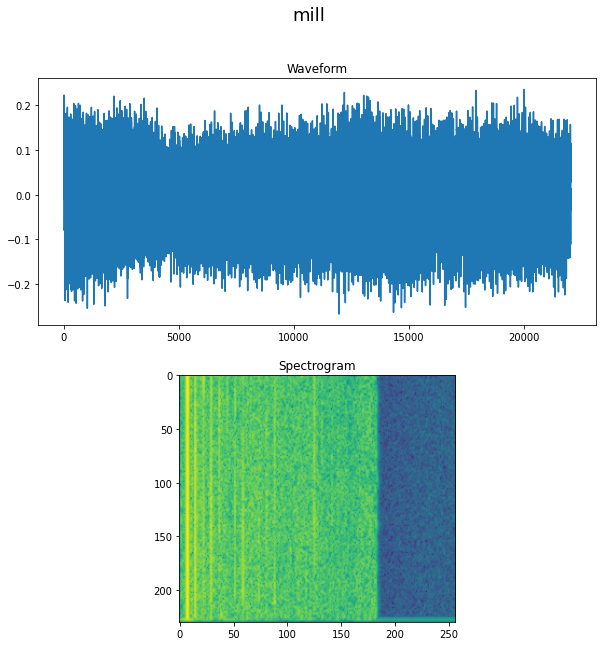

In [139]:
# Plotting a waveform along it's spectrogram
fig, axes = plt.subplots(2, figsize = (10, 10))

for waveform, label in waveform_dataset.take(1):
  spectrogram = get_spectrogram(waveform)
  axes[0].plot(waveform)
  axes[0].set_title("Waveform")
  axes[1].imshow(tf.math.log(spectrogram).numpy())
  axes[1].set_title("Spectrogram")
plt.suptitle(label.numpy().decode("utf-8"), fontsize = 18)
plt.show()

Now we're going to turn our waveform dataset into a spectrogram dataset. We'll
replace the labels for int values as well.

In [124]:
# Building the function
def get_spectrogram_and_label_id(waveform, label,
                                 frame_length = 512, frame_step = 96):
  """
  Takes in a tuple of a waveform and a label, and returns a tuple of a spectrogram
  and label_id.
  """
  spectrogram = get_spectrogram(waveform, frame_length = frame_length,
                                frame_step = frame_step)
  label_id = tf.argmax(label == labels)  # Get label index
  
  return spectrogram, label_id

In [130]:
# Aplying the function to the waveform dataset
spectrogram_dataset = waveform_dataset.map(
    map_func = get_spectrogram_and_label_id,
    num_parallel_calls = tf.data.AUTOTUNE
)

#### Visualizing some random spectrograms and their labels

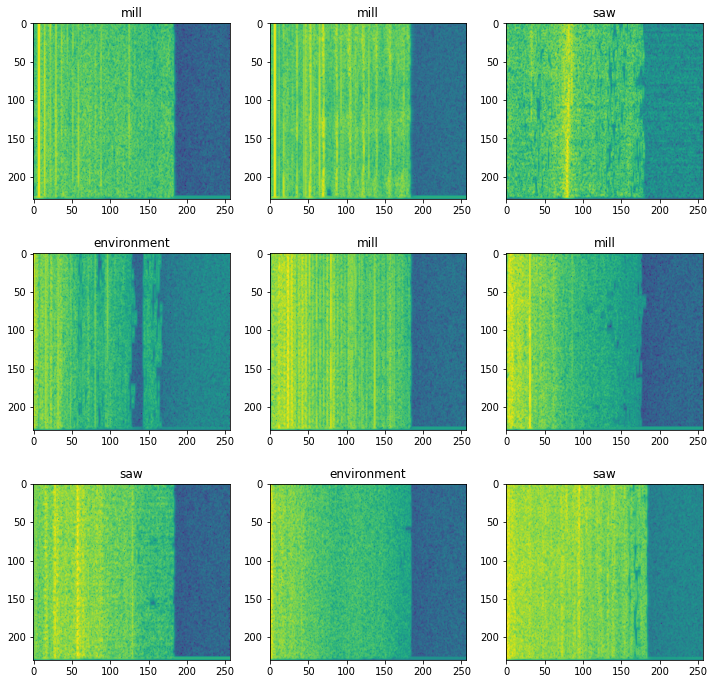

<Figure size 432x288 with 0 Axes>

In [143]:
# Plotting an array of spectrograms with their labels
num_rows = 3
num_cols = 3

n = num_rows*num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize = (12, 12))

for i, (spectrogram, label_id) in enumerate(spectrogram_dataset.take(n)):
  r = i // num_cols
  c = i % num_cols

  ax = axes [r][c]
  ax.set_title(labels[label_id.numpy()])
  ax.imshow(tf.math.log(spectrogram).numpy())

plt.show()
plt.savefig("/content/waveform_grid.png", dpi = 600)

### Preparing the dataset for Deep Learning experiments